# Analyzing Conditions to Win a League of Legends Match

Yuhwan Lee, Margaret Fang

## Introduction

League of Legends, commonly known as League or LoL, is a multiplayer online battle arena (MOBA) video game developed by Riot Games. It was released in 2009 and has become one of the most popular video games in the world. As of September 2022, there are more than 180 million active monthly users. The game is available on Windows and MacOS, and the modified mobile version called Wild Rift is available on android and iOS.  Because of the game's popularity, music videos, comic books, short stories, an animated series (Arcane), and several spin-off video games (Legends of Runeterra, Team Fight Tactics, etc.) have been made. Additionally, League of Legends is regularly cited as the world's largest esport as the 2019 League of Legends World Championship had 100 million unique viewers and peaked at 44 million concurrent viewers. 

There are a few gamemodes in League of Legends, but we will be focusing on the primary gamemode, Summoner's Rift. Two teams of five players compete and face off at opposing sides of the map. Each player controls a character, known as a champion, with unique abilities and playstyle. The objective of the game is to destroy the opposing team's Nexus, which is at the heart of the base. The Nexus is protected by towers and inhibitors. Minions are spawned by the Nexus and move towards the enemy base in waves along each lane. There are three lanes (top, middle, and bottom), and the area between lanes is called the jungle where neutral monsters are. Killing minions and neutral monsters gives players experience and gold, which they can use to level up skills and buy items from the shop to power up their champion. There are several large monsters (Rift Herald, Baron Nashor, Dragons) that can give buffs to a team when killed. More information on how to play the game can be found at https://www.leagueoflegends.com/en-us/how-to-play/. 

In this tutorial, our goal is to gather data on League of Legends Season 12 ranked matches from Iron to Diamond, organize the data, analyze some aspects that can contribute to winning a game, and compare those aspects across the ranks. League is constantly evolving. Every two weeks, a new patch comes out where bugs are fixed and new features and balances are made. Champions and items are constantly being buffed/nerfed and reworked. Because of the everchanging meta and large number of champions and items, we decided to focus on more patch agnostic factors such as map fairness, pings, objectives, and farming. League of Legends has a very steep learning curve and many aspects to the game. We hope that we will be able to help players understand what is important to winning and how to play like highly ranked players. Although it is much easier to understand our analysis with game knowledge, we hope that this tutorial can make readers who are unfamililar with the game more interested in trying out League of Legends.

## Table of Contents

>[Analyzing Conditions to Win a League of Legends Match](#scrollTo=7XzhaWj0FZAu)

>>[Introduction](#scrollTo=R2uF9yGyTUeB)

>>[Table of Contents](#scrollTo=fUYwiCuKXS-_)

>>[Getting Started](#scrollTo=FANbosgSUQ0-)

>[Data Wrangling](#scrollTo=MKgoZzPzTn8K)

>>[Riot API](#scrollTo=DTLmqHP5WZaP)

>>[Match Data](#scrollTo=yjWZPEODbiea)

>>[Creating DataFrame](#scrollTo=YrcyyrTqbzRp)

>>[Tidying Data](#scrollTo=ih1c_KlfZZL9)

>[Data Analysis](#scrollTo=_6_I-KW8bbmm)

>>[Blue Side vs Red Side?](#scrollTo=ez0CXoJipK53)

>>[Work in progress may delete later](#scrollTo=vhohdwUQc4ap)

>>[Pings](#scrollTo=7g_nm_FoxzpX)

>>[Objectives](#scrollTo=g41eY1Z2pQqt)

>>[Farming](#scrollTo=5108Hq6np-Ko)

>>[Tying it Together](#scrollTo=5LiDE3a4zbvi)

>[Conclusion](#scrollTo=T8HMdeGZgUi3)

>>[Further Exploration](#scrollTo=zUHXok_AgZK1)



## Getting Started

We use Python 3 with the following imported libraries listed below. Additionally, we are using Google Colab to run this Jupyter Notebook, and we mount this notebook to our Google Drive, so that we can save files and access them later. We create a folder in our Google Drive at "drive/MyDrive/google_colab_data/" to store files, which will be explained in more detail later.

In [ ]:
import requests
import json
import random
import os
import time
import itertools
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statistics
from scipy import stats
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Wrangling

Because we were unable to find a relevant and large dataset of League of Legends match data, we decided to create our own dataset by making calls to the Riot API and taking data from the Riot database. This allows us to be able to collect as much data as we need and filter on certain aspects like rank and season.

## Riot API

The Riot API and documentation can be accessed at https://developer.riotgames.com/, and you need a free Riot account to get an API key. A new API key can be generated at any time, and it expires after 24 hours.

In our analysis, we look at ranked SOLO/DUO queue matches from the North America server. We only look at matches from the ranks Iron, Silver, Gold, Platinum, and Diamond because Master, Grandmaster, and Challenger games are a little different and must be accessed with a different API endpoint.

In [3]:
# Reminder that default API key expires after 24 hours
API_KEY = "RGAPI-327d2787-6630-4cc3-a83c-9d523d0659a9"

# North America server
URL = "https://na1.api.riotgames.com"
AMERICAS_ROUTING_URL = "https://americas.api.riotgames.com"

# Queue ids: https://static.developer.riotgames.com/docs/lol/queues.json
QUEUE_ID = 420
QUEUE = "RANKED_SOLO_5x5"

# Ranked tiers and divisons
TIERS = ["IRON", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND"]
DIVISIONS = ["IV", "III", "II", "I"]
RANKED_ORDER = []
for tier in TIERS:
  for division in DIVISIONS:
    RANKED_ORDER.append(tier + "_" + division)

The Riot API has rate limits in place of 20 requests every 1 second and 100 requests every 2 minutes. To ensure that we do not surpass these rate limits, we create a global variable num_api_calls and a function wait_api_rate_limits(), which keeps track of the number of API calls and sleeps for an appropriate amount of time after we have hit the rate limits. Each time we make an API call, we can call this method to help us manage rate limits.

In [4]:
# Keep track of the number of API calls for rate limiting
# Riot API allows for 20 requests every second, and 100 requests every 2 minutes
num_api_calls = 0

# Wait for API calls
def wait_api_rate_limits():
  global num_api_calls
  # print("num", num_api_calls)
  num_api_calls += 1

  if num_api_calls % 20 == 0:
    time.sleep(1)  # Sleep 1 second for every 20 api calls

  if num_api_calls % 100 == 0:
    print(f"Reached {num_api_calls} calls, sleeping for 2 minutes")
    time.sleep(120)  # Sleep 2 minutes for every 100 api calls

There is no endpoint that will get a certain number of matches from a rank. Because the Riot API is very limited, the process to get a list of matches per rank is very long and requires many API calls. 

1. We first get a list of players' summoner IDs from a certain rank with the endpoint "/lol/league/v4/entries/{queue}/{tier}/{division}". 
2. We get each player's puuid with the endpoint "/lol/summoner/v4/summoners/{encryptedSummonerId}".
3. We get a list of recent match IDs from each player with the endpoint "/lol/match/v5/matches/by-puuid/{puuid}/ids"
4. We get match data for each match with the endpoint "/lol/match/v5/matches/{matchId}"

Below are the functions we create for each API call to help our code be more readable. Note that to get matches from each player, we get 100 matches from 02/01/2022 to 10/30/2022, which would be League of Legends Season 12. Then, we get a random sample of 5 matches from those 100 matches.

In [5]:
# Get a list of summoners given a specific tier and division
def get_summoner_ids(tier, division, count):
  summoner_ids = []
  url = f"{URL}/lol/league/v4/entries/{QUEUE}/{tier}/{division}"
  params = {"api_key" : API_KEY}

  wait_api_rate_limits()
  r = requests.get(url, params=params)
  if not r.ok:  # If response is an error
    print(r.content)

  # This endpoint returns 205 entries per page - page is a query parameter that can be passed
  data = json.loads(r.content)
  
  for entry in data:
    if len(summoner_ids) == count:
      break
    summoner_ids.append(str(entry["summonerId"]))

  return summoner_ids

# Get the corresponding puuids of users given a list of summoner ids
def get_puuids(summoner_ids):
  puuids = []
  
  for summoner_id in summoner_ids:
    url = f"{URL}/lol/summoner/v4/summoners/{summoner_id}"
    params = {"api_key" : API_KEY}

    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)

    data = json.loads(r.content)

    puuids.append(data["puuid"])

  return puuids

# Get a list of ranked matches played by a list of players
# For each user, get 100 matches from 02/01/2022 to 10/30/2022, and take
# a random sample of 5 matches from those matches
def get_match_ids_by_puuids(puuids):
  match_ids = []

  for puuid in puuids:
    url = f"{AMERICAS_ROUTING_URL}/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {
        "api_key" : API_KEY,
        "queue": QUEUE_ID,
        "startTime": 1643691600,  # 02/01/2022 12:00:00am
        "endTime": 1667088000,    # 10/30/2022 12:00:00am
        "count": 100
      }

    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)

    # List of strings, by default returns 20 strings, can set count from 0 to 100
    # Also has parameters start time and end time, and queue
    data = json.loads(r.content)

    # Get random sample of 5 matches from this list
    if len(data) >= 5:
      data = random.sample(data, 5)
    match_ids.extend(data)

  return match_ids

# Get match data given a list of match ids
def get_matches_by_match_ids(match_ids):
  matches = []
  for match_id in match_ids:
    url = f"{AMERICAS_ROUTING_URL}/lol/match/v5/matches/{match_id}"
    params = {
        "api_key" : API_KEY,
      }
    wait_api_rate_limits()
    r = requests.get(url, params=params)
    if not r.ok:  # If response is an error
      print(r.content)
    data = json.loads(r.content)
    matches.append(data)
  return matches

Now, we finally make the API calls and collect the data. For each tier and division, we first get a list of 100 players' summoner IDs (who are in that tier and division) and get their puuids. Next, we get 5 random Season 12 ranked matches from each user and get match data for each match. The data is written to a json file and saved. There is a separate json file for each tier and division. 

The entire runtime of making the API calls and collecting data takes several hours because of rate limits. Because we want the files to be stored in a permanent location, we download the json files and upload them to the folder "drive/MyDrive/google_colab_data/". At the end of the code block below, the call to downloaded_data() is commented out since we only need to do this process once.

In [6]:
def download_data():
  for tier in TIERS:
    for division in DIVISIONS:
      print(f"On {tier} {division}")
      # Get a list of 100 summoners by tier and division (1 API call)
      print("getting summoner ids")
      summoner_ids = get_summoner_ids(tier, division, 100)
      # Get the corresponding puuids of each summoner returned (100 API calls)
      print("getting puuids")
      puuids = get_puuids(summoner_ids)
      # Get 5 random ranked matches from each user (100 API calls)
      print("getting match ids")
      match_ids = get_match_ids_by_puuids(puuids)
      # Get match data for each match id (5*100 = 500 API Calls)
      print("getting matches")
      match_data = get_matches_by_match_ids(match_ids)
      print("number of matches found:", len(match_data))
      # Write match data to a file
      with open(f"{tier}_{division}_matches.json", "w") as file:
        json.dump(match_data, file)

# download_data()

## Match Data

The data for each match is very extensive. The print statements below show the data stored at different parts of the json, and they have been commented out due to the lengthy output. 

We find the following sections to contain worthwhile information.

*   match["info"]["gameDuration"] - Contains the game duration.
*   match["info"]["teams"] - Contains information about champion bans and objectives (baron, dragon, rift herald, towers, inhibitors) that each team has taken.
*   json.dumps(match["info"]["participants"] - Contains information for each individual player in the game such as role, champion, kills, deaths, assists, damage, gold earned, experience earned, creep score, vision score, etc. 

There are many more statistics saved, but we have picked what we think is important in our analysis, which is all information on objectives from team data and the statistics listed in participants data above.

In [7]:
with open("drive/MyDrive/google_colab_data/PLATINUM_IV_matches.json", "r") as file:
  data = json.load(file)
  match = data[0]
  # print(json.dumps(match, indent=4))

# print(match.keys())
# print(match["metadata"])
# print(match["info"].keys())
# print(json.dumps(match["info"]["gameDuration"]))
# print(json.dumps(match["info"]["gameType"]))
# print(json.dumps(match["info"]["gameVersion"]))
# print(json.dumps(match["info"]["platformId"]))
# print(json.dumps(match["info"]["mapId"]))
# print(json.dumps(match["info"]["teams"], indent=4))
# print(json.dumps(match["info"]["participants"][0], indent=4))

## Creating DataFrame

We must pull out relevant data and convert it to a pandas dataframe for ease of data access and analysis. We loop through the tiers and divisons to access each json file and then pull relevant data into a 2D array. We then convert our 2D array into a Pandas dataframe.

In [8]:
all_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": [],
    "blueFirstBaron": [],
    "blueNumBaron": [],
    "blueFirstChampion": [],
    "blueNumChampion": [],
    "blueFirstDragon": [],
    "blueNumDragon": [],
    "blueFirstInhibitor": [],
    "blueNumInhibitor": [],
    "blueFirstRiftHerald": [],
    "blueNumRiftHerald": [],
    "blueFirstTower": [],
    "blueNumTower": [],

    "blueNumPings": [],
    "blueNumAssists": [],
    "blueTotalExp": [],
    "blueTotalGold": [],
    "blueTotalCC": [],
    "blueTotalDamage": [],
    "blueTotalCS": [],
    "blueTotalVisionScore": [],

    "redFirstBaron": [],
    "redNumBaron": [],
    "redFirstChampion": [],
    "redNumChampion": [],
    "redFirstDragon": [],
    "redNumDragon": [],
    "redFirstInhibitor": [],
    "redNumInhibitor": [],
    "redFirstRiftHerald": [],
    "redNumRiftHerald": [],
    "redFirstTower": [],
    "redNumTower": [],

    "redNumPings": [],
    "redNumAssists": [],
    "redTotalExp": [],
    "redTotalGold": [],
    "redTotalCC": [],
    "redTotalDamage": [],
    "redTotalCS": [],
    "redTotalVisionScore": []
}

# Convert data into dictionary
# Iterate through tiers and divisions
for tier in TIERS:
  for division in DIVISIONS:
    # Open json file in Google Drive
    with open(f"drive/MyDrive/google_colab_data/{tier}_{division}_matches.json", "r") as file:
      data = json.load(file)

      for match in data:
        # Handles missing data
        if len(match["info"]["teams"]) < 2:
          continue

        all_data["gameDuration"].append(match["info"]["gameDuration"])
        all_data["gameRankDivision"].append(tier + "_" + division)
        all_data["gameRank"].append(tier)
        all_data["gameDivision"].append(division)

        # Team_data contains two objects, one for each team
        team_data = match["info"]["teams"]
        # Make sure blue team comes first in the list
        team_data.sort(key=lambda team: team["teamId"])
        for team in team_data:
          team_name = "blue" if team["teamId"] == 100 else "red"

          # Adds team that won
          if team["win"]:
            all_data["teamWin"].append(team_name)

          # Add all team related data
          # Data about objectives taken
          for objective_name in team["objectives"]:
            # Capitalize name of objective for dictionary key
            cap_obj_name = objective_name[:1].upper() + objective_name[1:]
            all_data[f"{team_name}First{cap_obj_name}"].append(team["objectives"][objective_name]["first"])
            all_data[f"{team_name}Num{cap_obj_name}"].append(team["objectives"][objective_name]["kills"])


        participant_data = {"blueNumPings": 0, "blueNumAssists": 0, "blueTotalExp": 0, "blueTotalGold": 0,
                            "blueTotalCC": 0, "blueTotalDamage": 0, "blueTotalCS": 0, "blueTotalVisionScore": 0,
                            "redNumPings": 0, "redNumAssists": 0, "redTotalExp": 0, "redTotalGold": 0,
                            "redTotalCC": 0, "redTotalDamage": 0, "redTotalCS": 0, "redTotalVisionScore": 0
                            }

        for participant in match["info"]["participants"]:
          team_name = "blue" if participant["teamId"] == 100 else "red"
          participant_data[f"{team_name}NumPings"] += participant["basicPings"] if "basicPings" in participant.keys() else 0 # Handles missing data
          participant_data[f"{team_name}NumAssists"] += participant["assists"]
          participant_data[f"{team_name}TotalExp"] += participant["champExperience"]
          participant_data[f"{team_name}TotalGold"] += participant["goldEarned"]
          participant_data[f"{team_name}TotalCC"] += participant["timeCCingOthers"]
          participant_data[f"{team_name}TotalDamage"] += participant["totalDamageDealtToChampions"]
          participant_data[f"{team_name}TotalCS"] += participant["totalMinionsKilled"] + participant["neutralMinionsKilled"]
          participant_data[f"{team_name}TotalVisionScore"] += participant["visionScore"]
        for key in participant_data:
          all_data[key].append(participant_data[key])

In [9]:
# Build pandas DataFrame from dictionary
match_df = pd.DataFrame.from_dict(all_data)
match_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,blueFirstBaron,blueNumBaron,blueFirstChampion,blueNumChampion,blueFirstDragon,...,redFirstTower,redNumTower,redNumPings,redNumAssists,redTotalExp,redTotalGold,redTotalCC,redTotalDamage,redTotalCS,redTotalVisionScore
0,blue,IRON_IV,IRON,IV,2103,True,1,True,39,False,...,False,4,147,21,71283,57043,56,91163,805,136
1,blue,IRON_IV,IRON,IV,1688,True,1,False,34,True,...,True,6,59,28,49651,47421,41,64165,585,101
2,red,IRON_IV,IRON,IV,1465,False,0,False,15,False,...,True,11,55,18,51099,45670,49,52085,609,80
3,blue,IRON_IV,IRON,IV,963,False,0,True,17,True,...,False,0,22,4,25951,19354,47,18135,295,26
4,red,IRON_IV,IRON,IV,2014,False,0,True,26,False,...,True,9,121,45,73586,65526,122,111373,678,127


## Tidying Data

1. A typical League of Legends match is around 20-40 minutes long. Games that end before 5 minutes are not a good representation of data, as they most likely occur due to a player disconnecting or idling. Thus, we remove all games under 5 minutes from our data. 

2. We also rename some of our columns so that it is more intuitive. NumChampion stands for the number of kills and FirstChampion indicates if the team had the first kill in the game, which is a term called first blood in the game. Let us rename these columns to NumKills and FirstBlood.

4. We make sure that the gameRankDivision has ordered categorical data because the ranks are ordered from IRON IV to DIAMOND 1.

In [10]:
print("Number of games:", len(match_df))
print("Number of games lasting less than 3 minutes:", len(match_df[match_df["gameDuration"] < 180]))
print("Number of games lasting less than 5 minutes:", len(match_df[match_df["gameDuration"] < 300]))
print("Number of games lasting less than 15 minutes:", len(match_df[match_df["gameDuration"] < 900]))

# Games lasting less than 5 minutes are bogus, so we will just remove them.
match_df = match_df[match_df["gameDuration"] > 300]

# Rename some columns for better readibility
match_df = match_df.rename(columns = {"blueNumChampion" : "blueNumKills", "redNumChampion" : "redNumKills", 
                           "blueFirstChampion" : "blueFirstBlood", "redFirstChampion" : "redFirstBlood"})

# Make game rank ordered
match_df.gameRankDivision = pd.Categorical(match_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
match_df.gameRank = pd.Categorical(match_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

match_df.head()

Number of games: 11572
Number of games lasting less than 3 minutes: 0
Number of games lasting less than 5 minutes: 118
Number of games lasting less than 15 minutes: 261


,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,blueFirstBaron,blueNumBaron,blueFirstBlood,blueNumKills,blueFirstDragon,...,redFirstTower,redNumTower,redNumPings,redNumAssists,redTotalExp,redTotalGold,redTotalCC,redTotalDamage,redTotalCS,redTotalVisionScore
0,blue,IRON_IV,IRON,IV,2103,True,1,True,39,False,...,False,4,147,21,71283,57043,56,91163,805,136
1,blue,IRON_IV,IRON,IV,1688,True,1,False,34,True,...,True,6,59,28,49651,47421,41,64165,585,101
2,red,IRON_IV,IRON,IV,1465,False,0,False,15,False,...,True,11,55,18,51099,45670,49,52085,609,80
3,blue,IRON_IV,IRON,IV,963,False,0,True,17,True,...,False,0,22,4,25951,19354,47,18135,295,26
4,red,IRON_IV,IRON,IV,2014,False,0,True,26,False,...,True,9,121,45,73586,65526,122,111373,678,127


Now we have data split between blue and red team. To perform analysis on what factors contribute to a win, we will "normalize" the data by taking the difference of the winning team's value of a certain stat by the losing team's corresponding value, e.g. if blue won, we would take blueNumChampion - redNumChampion. We will also normalize the data in the perspective of blue side, so that the difference will always be blue minus red.

In [11]:
# Dataframe where all values are relative to winning team
normalized_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": []
}

# Dataframe where all values are relative to blue team
blue_side_data = {
    "teamWin": [],
    "gameRankDivision": [],
    "gameRank": [],
    "gameDivision": [],
    "gameDuration": []
}

# Create difference fields
team_stat_names = list(map(lambda blue_field_name: blue_field_name[4:], filter(lambda field: field.startswith("blue"), match_df)))
for team_stat in team_stat_names:
  normalized_data["diff" + team_stat] = []
  blue_side_data["diff" + team_stat] = []

# Go row by row and calculate these new fields
for index, row in match_df.iterrows():
  # teamWin will be 1 if blue won the game, 0 if red won
  teamWin = row["teamWin"]
  normalized_data["teamWin"].append(int(row["teamWin"] == "blue"))
  normalized_data["gameRankDivision"].append(row["gameRankDivision"])
  normalized_data["gameRank"].append(row["gameRank"])
  normalized_data["gameDivision"].append(row["gameDivision"])
  normalized_data["gameDuration"].append(row["gameDuration"])

  blue_side_data["teamWin"].append(int(row["teamWin"] == "blue"))
  blue_side_data["gameRankDivision"].append(row["gameRankDivision"])
  blue_side_data["gameRank"].append(row["gameRank"])
  blue_side_data["gameDivision"].append(row["gameDivision"])
  blue_side_data["gameDuration"].append(row["gameDuration"])

  for team_stat in team_stat_names:
    # Boolean stats are treated differently
    # A boolean that is true for blue will always be false for red, and vice versa
    # So, true for winning team will correspond to 1 in our normalized data

    # If this is a boolean field:
    if type(row["blue" + team_stat]) == type(True):
      normalized_data["diff" + team_stat].append(int(row[teamWin + team_stat]))
      blue_side_data["diff" + team_stat].append(int(row["blue" + team_stat]))
    else:
      teamLose = "red" if teamWin == "blue" else "blue"
      normalized_data["diff" + team_stat].append(
          row[teamWin + team_stat] - row[teamLose + team_stat]
      )
      blue_side_data["diff" + team_stat].append(
          row["blue" + team_stat] - row["red" + team_stat]
      )

In [12]:
normalized_df = pd.DataFrame.from_dict(normalized_data)
blue_side_df = pd.DataFrame.from_dict(blue_side_data)

# Make game rank ordered
normalized_df.gameRankDivision = pd.Categorical(normalized_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
normalized_df.gameRank = pd.Categorical(normalized_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

blue_side_df.gameRankDivision = pd.Categorical(blue_side_df.gameRankDivision, 
                      categories=RANKED_ORDER,
                      ordered=True)
blue_side_df.gameRank = pd.Categorical(blue_side_df.gameRank, 
                      categories=TIERS,
                      ordered=True)

normalized_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,diffFirstBaron,diffNumBaron,diffFirstBlood,diffNumKills,diffFirstDragon,...,diffFirstTower,diffNumTower,diffNumPings,diffNumAssists,diffTotalExp,diffTotalGold,diffTotalCC,diffTotalDamage,diffTotalCS,diffTotalVisionScore
0,1,IRON_IV,IRON,IV,2103,1,1,1,21,0,...,1,7,-133,4,1034,8430,171,14534,0,-53
1,1,IRON_IV,IRON,IV,1688,1,1,0,8,1,...,0,4,23,-5,13894,7649,-1,13638,-21,-47
2,0,IRON_IV,IRON,IV,1465,0,0,1,4,1,...,1,11,-2,10,9805,13633,23,15673,242,41
3,1,IRON_IV,IRON,IV,963,0,0,1,13,1,...,1,3,36,9,6034,9783,-5,12810,58,18
4,0,IRON_IV,IRON,IV,2014,1,2,0,18,1,...,1,4,-51,8,4963,9776,-62,18737,81,9


# Data Analysis

## Blue Side vs Red Side?


The first thing we will explore is the difference between blue side and red side. In League of Legends, the map is almost symmetrical, with a few differences. Ideally, the side should not matter for players, and the win rates for both sides should be around 50%. However, the playerbase seems to prefer being on blue side because there are nuances with camera angle and the HUD (display bar) being on the bottom side, which may make playing on the red side more uncomfortable. Blue side is also the side that new players start out on (all tutorials and bot games).

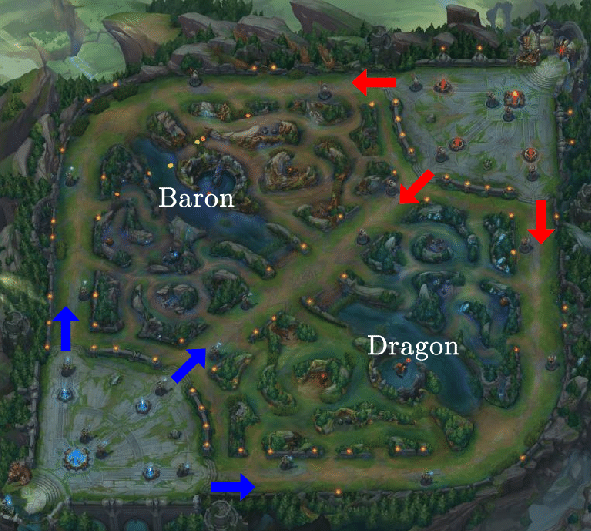

From: https://www.researchgate.net/figure/Map-of-Summoners-Rift_fig1_339003417

In [13]:
# Display percentage of blue wins and red wins
match_df["teamWin"].value_counts(normalize=True)

blue    0.512572
red     0.487428
Name: teamWin, dtype: float64

We see that on average, blue side has a slightly higher winrate. Let us determine if this difference is significant. We use a right-tailed one sample T test to check whether or not the true average value of team win is statistically greater than 0.5. Remember that the teamWin column has 0 for red side winning and 1 for blue side winning. Essentially, we are checking if the blue side winrate is statistically greater than 50%. We use scipy package to perform the hypothesis test.

In [14]:
# Right-tailed one sample T test
stats.ttest_1samp(normalized_df["teamWin"], popmean=0.5, alternative="greater")

Ttest_1sampResult(statistic=2.691734794007755, pvalue=0.003559236277464431)

Since the p-value is less than a significance level of 0.05, we can conclude that the win percentage of blue side is statistically greater than 50%. Wow, looks like the map is not fair.

Next, let us see how rank affects the blue side winrate. It is possible that higher ranked players are able to play effectively on both blue and red side which would lead to a blue side winrate closer to 50%.

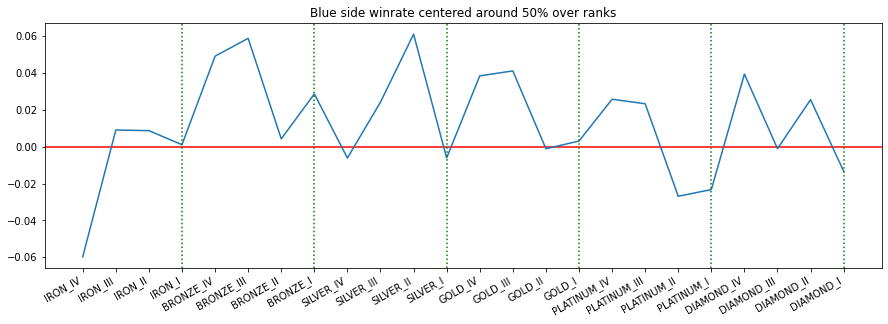

In [15]:
# Get blue side winrate minus 0.5 for each rank
val_counts = match_df.groupby("gameRankDivision")["teamWin"].value_counts(normalize=True)
arr = []
for rank in RANKED_ORDER:
  arr.append(val_counts[rank]["blue"] - .5)
  # Prints out rank that blue side winrate is under 0.5
  # if (val_counts[rank]["blue"] - .5) < 0:
  #  print(rank)

# Plot graph
fig, ax = plt.subplots(figsize=(15, 5))
plt.title("Blue side winrate centered around 50% over ranks")
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.plot(RANKED_ORDER, arr)
for tier in TIERS:
  plt.axvline(x = tier + "_I", color = 'g', linestyle = "dotted")
fig.autofmt_xdate()

plt.show()

The red line on the graph above shows the 50% winrate. The green lines divide between ranked tiers. We see that blue side usually has a winrate above 50%, and rank does not seem to be related with the blue side winrate.

From our findings, blue side averages to have a statistically significant higher winrate than red side, and it is not affected by rank.

## Work in progress may delete later

TODO todo

gameRank
IRON        4.895254
BRONZE      6.291866
SILVER      6.906819
GOLD        4.671197
PLATINUM    4.952478
DIAMOND     4.611596
Name: diffTotalCC, dtype: float64


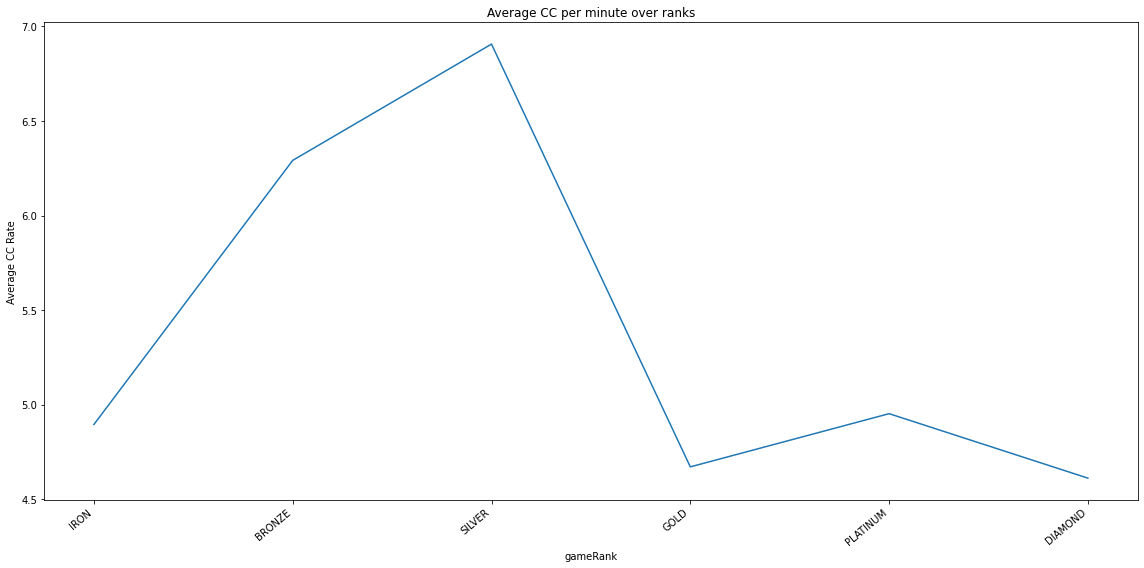

In [16]:
mean_cc = normalized_df.groupby("gameRank")["diffTotalCC"].mean()
print(mean_cc)

# Plot
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average CC Rate')
plt.title("Average CC per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_cc.index, y=mean_cc.values)
ax.set_xticklabels(TIERS, rotation=40, ha="right")
plt.tight_layout()
plt.show()

## Pings

Players use pings to quickly communicate with their team. The ping wheel is shown in the image below. The number of pings made can measure how much players communicate with each other. As a team game, communication is important and can influence wins and losses. We will try to see if there is a relationship between winning, rank, and pings.

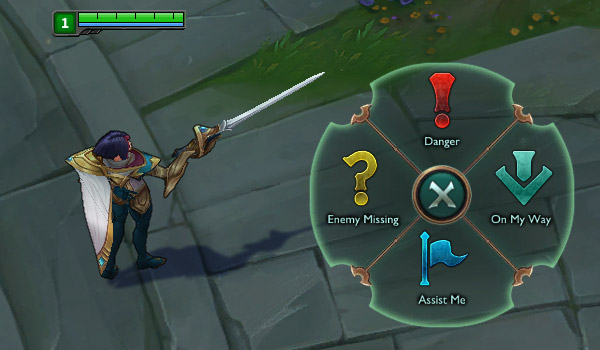


From: https://support-leagueoflegends.riotgames.com/hc/en-us/articles/201752974-Smart-Ping

Half of our data has 0 pings, which may be an issue with Riot's database. We remove these rows for our exploration of pings. Additionally, we must consider that longer games will result in more pings. Thus, we divide the number of pings by minute and get the pings per minute (pingRate) instead of just the number of pings.

Number of matches with 0 pings: 5854


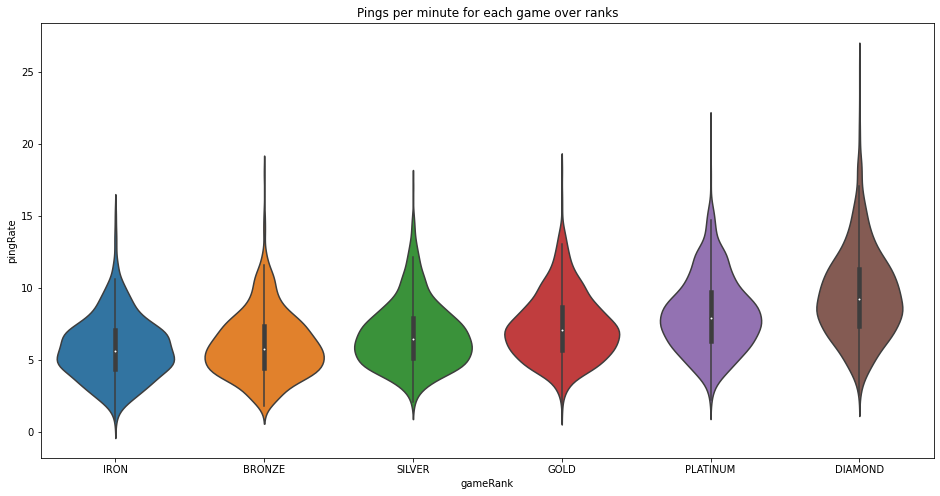

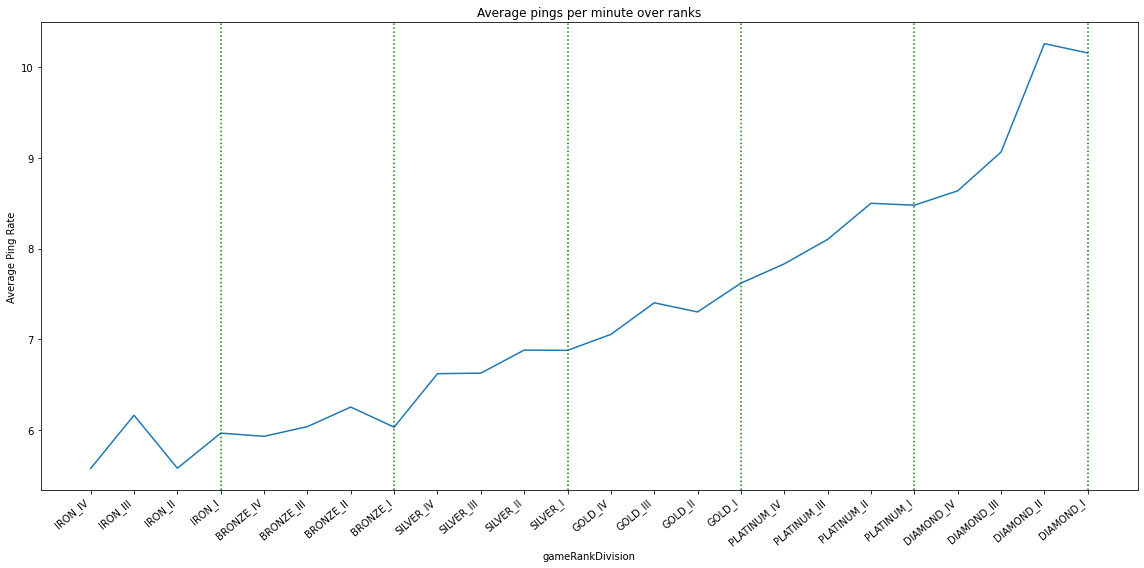

In [17]:
# Calculate total pings 
match_df["totalPings"] = match_df["blueNumPings"] + match_df["redNumPings"]
# Calculate pings per minute
match_df["pingRate"] = match_df["totalPings"] / match_df["gameDuration"] * 60

# Remove rows with 0 pings
print("Number of matches with 0 pings:", len(match_df[match_df["totalPings"] == 0]))
ping_df = match_df[match_df["totalPings"] != 0]

# Make violin plot where x-axis is rank and y-axis is ping rate per game
fig, ax = plt.subplots(figsize = (16,8))
plt.title("Pings per minute for each game over ranks")
ax = sns.violinplot(x=ping_df["gameRank"], y= ping_df["pingRate"])
plt.show()

# Get mean number of pings
mean_pings = ping_df.groupby("gameRankDivision")["pingRate"].mean()

# Plot line graph of mean pings per game across ranks
fig, ax = plt.subplots(figsize = (16,8))
ax.set(ylabel='Average Ping Rate')
plt.title("Average pings per minute over ranks")
ax = sns.lineplot(ax=ax, x=mean_pings.index, y=mean_pings.values)
ax.set_xticklabels(RANKED_ORDER, rotation=40, ha="right")
plt.tight_layout()
for tier in TIERS:
  plt.axvline(x = tier + "_I", color = 'g', linestyle = "dotted")
plt.show()


The first graph above is a violin plot of the number of pings per minute for each game over the ranks. The mean of the number of pings seems to increase as you go from lower rank to higher rank. The second graph shows the mean number of pings per minute over each rank and division. We see that the mean significantly increases across the ranks. From these graphs, it appears that higher ranked players use more pings.

Number of matches with diff pings at 0: 5895


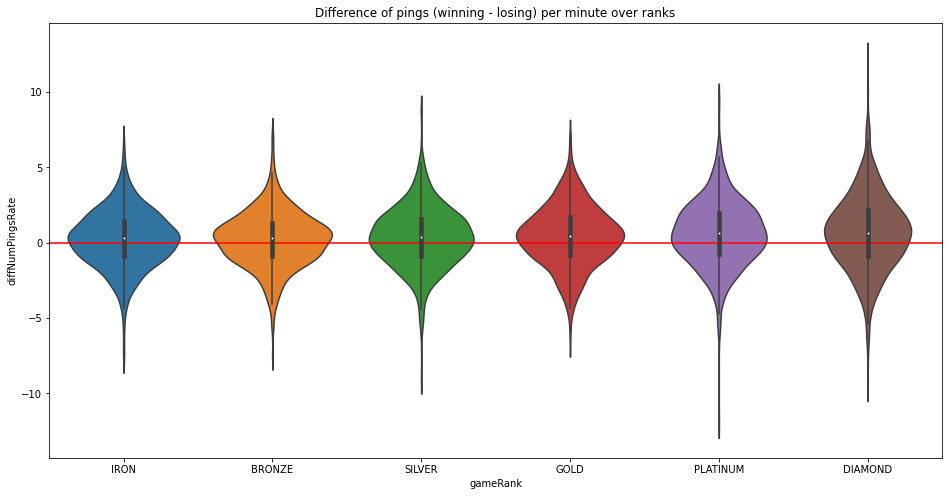

gameRank
IRON        0.250514
BRONZE      0.230478
SILVER      0.369181
GOLD        0.437399
PLATINUM    0.615528
DIAMOND     0.675831
Name: diffNumPingsRate, dtype: float64

In [18]:
# Remove games with diffNumPings = 0
print("Number of matches with diff pings at 0:", len(normalized_df[normalized_df["diffNumPings"] == 0]))
ping_df = normalized_df[normalized_df["diffNumPings"] != 0]

# Make difference in pings per minute
ping_df["diffNumPingsRate"] = (ping_df["diffNumPings"] / ping_df["gameDuration"]) * 60

# Create violin plot of difference in pings (winning team minus losing team) per minute over the ranks
fig, ax = plt.subplots(figsize = (16,8))
plt.axhline(y = 0, color = 'r', linestyle = '-')
ax.set(xlabel='Rank', ylabel='Difference in Pings')
plt.title("Difference of pings (winning - losing) per minute over ranks")
ax = sns.violinplot(x=ping_df["gameRank"], y= ping_df["diffNumPingsRate"])
plt.show()

# Print out means
ping_df.groupby("gameRank")["diffNumPingsRate"].mean()

The graph above is a violin plot of the difference of pings per minute over the ranks. This value is calculated by subtracting the number of pings of the losing team from the number of pings from the winning team and dividing by minutes. A value above 0 indicates that the winning team had more pings than the losing team, and a value below 0 indicates that the losing team had more pings than the winning team. Although very slight, the means are all above 0 and increases across the ranks. Thus, the winning team usually makes more pings and thus communicates more.

## Objectives

Objectives in League of Legends are certain things that a team can obtain to help them win the game. They include killing the neutral monsters Rift Herald, Baron Nashor, and dragons, as well as structures like towers and inhibitors. In our analysis, we will count player kills as objectives too because we want to compare the influence of kills with the influence of other objectives. Below we list a quick summary of what each objective does.

*   Rift Herald - An early game monster that spawns in the Baron pit before 
*   Baron Nashor - A late game monster that grants all living teammates a 180 second buff that gives bonus attack damage and ability power, and an aura that greatly empowers nearby minions.
*   Dragons - A type of monster that spawns throughout the game and grants a permanent buff to all players on the team. The team that obtains 4 dragons will get the dragon soul, which gives another permanent buff to all players on the team. After the dragon soul is obtained, elder dragons will spawn which grant a 150 second buff to all living teammates that helps obtain kills on enemy players.
*   Towers - Teams must destroy enemy towers to push their assault into enemy territory.
*   Inhibitors - Once a team destroys an enemy inhibitor, super minions are spawned in the respective lane, which help to push further into an enemy's base.
*   Kills - After a player is killed, they must wait for a duration (death timer) before respawning.



We want to see the influence of objectives on winning. Although typically you wouldn't use a regression to predict the value of a categorical variable (win or loss), we want to see how much different objectives factor in to how likely a team is to win. 

So, we will treat win/loss as a continuous variable, where 1 means blue wins, -1 means blue loses, and 0 means the team that wins at the end will be a tossup. For example, a low positive value means that the model slightly thinks blue will win, whereas a high positive value means that the model thinks blue will definitely win. The same can be said about red, which would be negative values.

From https://stattrek.com/multiple-regression/interaction, "In regression, an interaction effect exists when the effect of an independent variable on a dependent variable changes, depending on the value(s) of one or more other independent variables." This sounds exactly like what happens with game duration and every other variable. Impact of fields such as dragon differential changes depending on the length of the game. Having one extra dragon at 15 minutes is more of a "stomp" (overwhelming win) than having one extra dragon 35 minutes into the game.

Here, we use the normalized dataframe in perspective of blue team and change the teamWin column so that blue winning is 1 and red winning is -1.

In [19]:
# Normalize teamWin from 0 to 1 -> -1 to 1
regression_df = blue_side_df.copy()
regression_df["standardizedTeamWin"] = list(map(lambda teamWin: 1 if teamWin == 1 else -1, regression_df["teamWin"]))
regression_df.head()

,teamWin,gameRankDivision,gameRank,gameDivision,gameDuration,diffFirstBaron,diffNumBaron,diffFirstBlood,diffNumKills,diffFirstDragon,...,diffNumTower,diffNumPings,diffNumAssists,diffTotalExp,diffTotalGold,diffTotalCC,diffTotalDamage,diffTotalCS,diffTotalVisionScore,standardizedTeamWin
0,1,IRON_IV,IRON,IV,2103,1,1,1,21,0,...,7,-133,4,1034,8430,171,14534,0,-53,1
1,1,IRON_IV,IRON,IV,1688,1,1,0,8,1,...,4,23,-5,13894,7649,-1,13638,-21,-47,1
2,0,IRON_IV,IRON,IV,1465,0,0,0,-4,0,...,-11,2,-10,-9805,-13633,-23,-15673,-242,-41,-1
3,1,IRON_IV,IRON,IV,963,0,0,1,13,1,...,3,36,9,6034,9783,-5,12810,58,18,1
4,0,IRON_IV,IRON,IV,2014,0,-2,1,-18,0,...,-4,51,-8,-4963,-9776,62,-18737,-81,-9,-1


When looking at objectives, we only look at the number of objectives taken to simplify our analysis. We create our linear regression formula with interaction terms between all the objectives and the game duration.

In [20]:
# Linear regression formula
formula = "standardizedTeamWin ~ "\
            "gameDuration:diffNumBaron + "\
             "gameDuration:diffNumKills + "\
             "gameDuration:diffNumDragon + "\
             "gameDuration:diffNumInhibitor + "\
             "gameDuration:diffNumRiftHerald + "\
             "gameDuration:diffNumTower"
linreg = ols(formula=formula, data=regression_df).fit()

print(linreg.summary())

                             OLS Regression Results                            
Dep. Variable:     standardizedTeamWin   R-squared:                       0.802
Model:                             OLS   Adj. R-squared:                  0.802
Method:                  Least Squares   F-statistic:                     7727.
Date:                 Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                         18:15:46   Log-Likelihood:                -6974.4
No. Observations:                11454   AIC:                         1.396e+04
Df Residuals:                    11447   BIC:                         1.401e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
In

As we can see, the F-statistic is ~7727, with a very low p-value. Thus, the influence of objectives on the probability of winning is very high, as one might expect.



Let's view some sample coefficient values if we set the game duration to 30 minutes.

In [21]:
# Coefficient values at 30 minutes
print(linreg.params.apply(lambda x: x*1800))

Intercept                         12.429337
gameDuration:diffNumBaron          0.035018
gameDuration:diffNumKills          0.020241
gameDuration:diffNumDragon         0.020349
gameDuration:diffNumInhibitor     -0.044492
gameDuration:diffNumRiftHerald    -0.011209
gameDuration:diffNumTower          0.112458
dtype: float64


As you can see, some of the coefficients of our features are negative. There are two possible interpretations to negative coefficients: a negative coefficient means that either the corresponding feature becomes less important as the games get longer in duration, or obtaining the corresponding objective is actually detrimental to a team's success. We are inclined to go with the former explanation because all objectives are designed to help the team win. The objectives with negative coefficients, the number of inhibitors and Rift Heralds gained, can be explained with some game knowledge. These two objectives definitely seem to have less impact as the game gets longer. Rift Herald is an early game objective, that usually gets a tower for the team, and it does not give a permanent buff. Getting an inhibitor early is a sign that a team is stomping very hard and is thus more likely to win the game, since inhibitors are inside the base and you need to get all the towers in a lane before you can get the inhibitor. However, the longer a game drags on with inhibitors taken, the more gold you are giving the enemy team because of super minions, so, getting inhibitors early on is actually detrimental.

It seems that the most important objective to get is towers. This makes sense, as destroying towers is the only way to get deeper into an enemy's base, and thus destroy the nexus and winning the game.

We are curious if certain objectives matter more in higher ranks because players are able to utilize their benefits better.

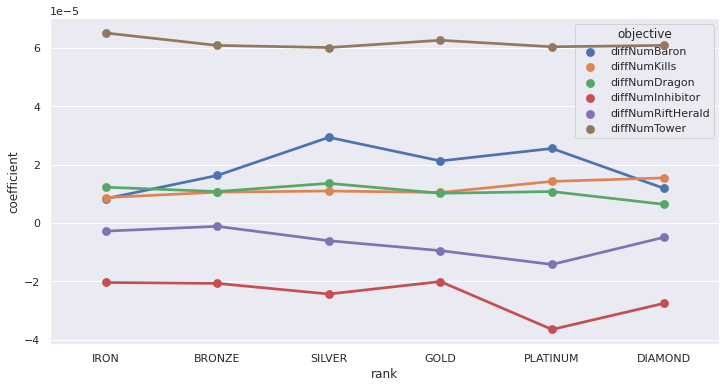

In [22]:
coefficient_data = {
    "rank": [],
    "objective": [],
    "coefficient": []
}

# Groups by rank and makes regression for each rank
for name, group in regression_df.groupby("gameRank"):
  linreg = ols(formula=formula, data=group).fit()
  for objective, coef in linreg.params.items():
    if objective == "Intercept":
      continue
    objective = objective.split(":")[1]
    coefficient_data["rank"].append(name)
    coefficient_data["objective"].append(objective)
    coefficient_data["coefficient"].append(coef)
      

# Make df from coefficient data
coefficient_df = pd.DataFrame.from_dict(coefficient_data)

# Graph coefficients
sns.set(rc={'figure.figsize':(12, 6)})
sns.pointplot(data=coefficient_df, x="rank", y="coefficient", hue="objective")

The graph above shows how the coefficient of each objective changes across the ranks. From this graph, we can see that the influence of most objectives is not affected by ranks. The only objective that might have a trend with rank is player kills, as its coefficient seems to slightly increase across the ranks. After obtaining a kill, higher ranked players are able to better utilize this advantage to further their advantage. 

## Farming

In League of Legends, gold is very important because you use gold to buy items in the shop that can make your champion get stronger. Experience is also important because your champion gets stronger as you level up. The primary method for players to get gold and experience is through farming, which is killing non-player mobs (minions, jungle camps). Your creep score (CS) counts how many minions/camps you've killed, and essentially is your farm score. 

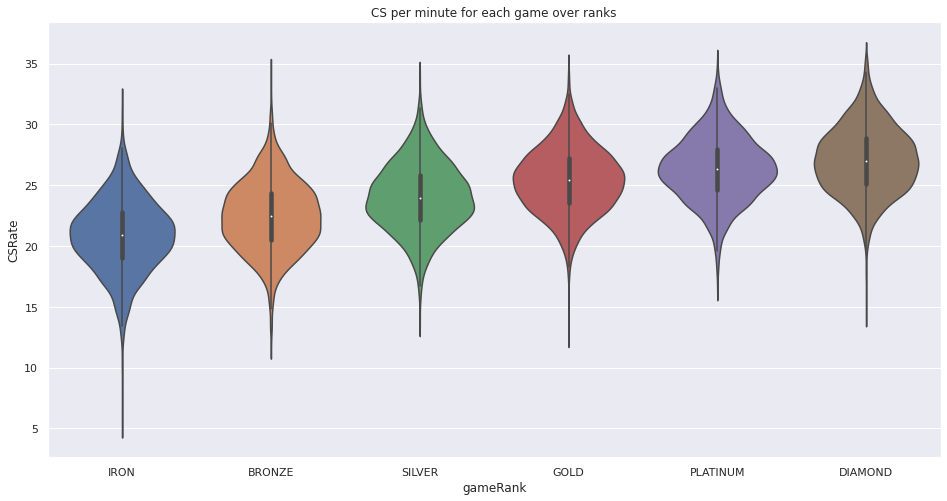

In [23]:
# Calculate total CS 
match_df["totalCS"] = match_df["blueTotalCS"] + match_df["redTotalCS"]
# Calculate CS per minute
match_df["CSRate"] = match_df["blueTotalCS"] / match_df["gameDuration"] * 60

# There are no games with 0 CS, no missing data
# print("Number of matches with 0 pings:", len(match_df[match_df["totalCS"] == 0]))

# Make violin plot where x-axis is rank and y-axis is CS rate per game
fig, ax = plt.subplots(figsize = (16,8))
plt.title("CS per minute for each game over ranks")
ax = sns.violinplot(x=match_df["gameRank"], y= match_df["CSRate"])
plt.show()

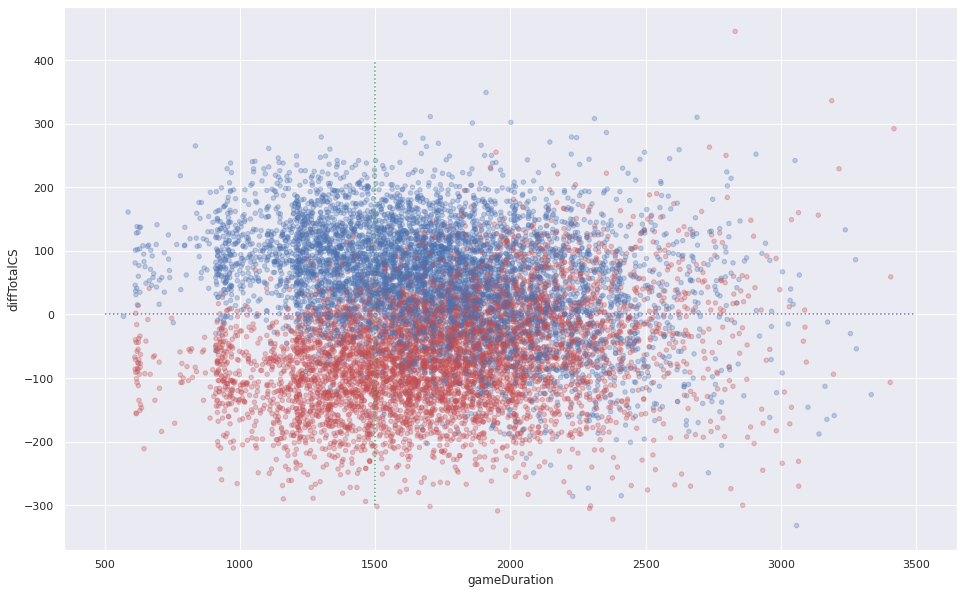

In [24]:
# Make scatter plot of CS and time
blue_side_df.plot.scatter(x='gameDuration',
                       y='diffTotalCS',
                       alpha=.3,
                       figsize=(16,10),
                       c=blue_side_df.teamWin.map({1: "b", 0: "r"}))

plt.plot([500, 3500], [0, 0], color='m', linestyle='dotted', linewidth=1.5, alpha=1)
plt.plot([1500, 1500], [-300, 400], color='g', linestyle='dotted', linewidth=1.5, alpha=1)


The scatter plot above shows the difference in CS (blue - red) for each game over the duration of the game. A point above 0 means that the blue team had more CS and a point below 0 means that the red team had more CS. The color of each point indicates the team that won. 

Before 1500 seconds (25 minutes), having more CS than the other team seems to be a very clear sign of which team will win, while the trend seems to diverge pretty heavily after 1500 seconds. Thus, we think that we should treat these two sections of the game differently in further analysis. 

delete this probably --- To see how CS influences a game's win, we choose a logistic regression because we want a classification algorithm, and a logistic regression also gives us probabilities of a certain match being a blue or red win. We predict that any classifier on CS will have less confidence when predicting games that are longer in duration because the blue and red points seem to mix heavily for longer games, as shown in the scatter plot. ---

an interesting metric to analyze in this section is the "predictability" of a match with respect to the CS differential - if a team has a positive CS differential, how likely are they to win at different stages of the game?

we will calculate "predictability" by taking the proportion of games that are "properly" placed with regards to the cs differential. i.e., a blue win with a positive cs differential is properly placed, a red win with a positive is improper. a blue win with negative cs differential is improper, a red win with negative is proper.

i am going to bin games by the minute for this calculation.
nvm, binning by every 5 mins

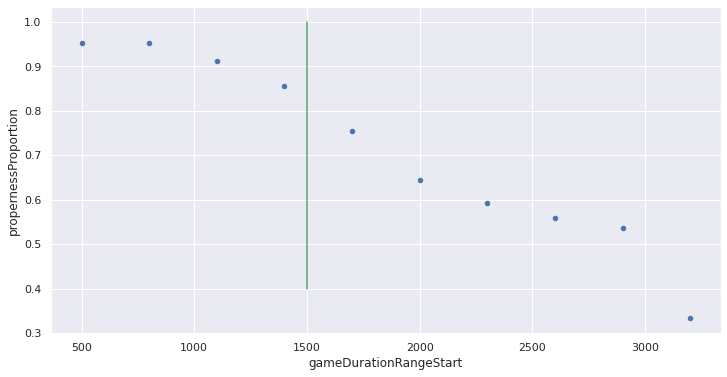

In [25]:
# given a match, determine if it is proper according to the 
# team that won and the cs differential.
def label_properness(row):
  # if blue won, the game is proper if the cs differential was positive
  if row["teamWin"] == 1 and row["diffTotalCS"] > 0:
    return True
  # if red won, the game is only proper if cs differential was negative
  if row["teamWin"] == 0 and row["diffTotalCS"] < 0:
    return True
  # otherwise, the game is improper
  return False


# we make a new df containing "properness" - whether or not the game is proper
# according to the team win and cs differential.
properness_df = blue_side_df[["gameDuration", "gameRank"]]
properness_df["properness"] = blue_side_df.apply(label_properness, axis=1)
# note the longest game is ~3500 seconds long. binning by every 5 minute, every 300 secs
RANGE = 300
# properness proportion is the proportion of games in the given time range are proper
properness_proportions_data = {
    "gameDurationRangeStart": [],
    "propernessProportion": []
}
for start_time in range(500, 3500, RANGE):
  end_time = start_time + (RANGE - 1)
  # get all games in the given time range
  time_range = properness_df[properness_df["gameDuration"].between(start_time, end_time, inclusive="both")]

  properness_proportions_data["gameDurationRangeStart"].append(start_time)
  # calculate the proportion of proper games in this time range
  prop_proportion = np.nan if len(time_range) == 0 else len(time_range[time_range["properness"]]) / len(time_range)
  properness_proportions_data["propernessProportion"].append(prop_proportion)

properness_proportions_df = pd.DataFrame.from_dict(properness_proportions_data)
# make scatter plot of these proportions
properness_proportions_df.plot.scatter(x="gameDurationRangeStart", y="propernessProportion")
plt.plot([1500, 1500], [.4, 1], color='g', linewidth=1.5, alpha=1)


as we might expect, the predictability of games decreases as game duration increases if we are only looking at cs differential.

In [26]:
# Create logistic regression model - PROBABLY DELETE
"""
X = blue_side_df[["gameDuration", "diffTotalCS"]]
y = blue_side_df["teamWin"]
logistic_model = LogisticRegression().fit(X, y)
"""

'\nX = blue_side_df[["gameDuration", "diffTotalCS"]]\ny = blue_side_df["teamWin"]\nlogistic_model = LogisticRegression().fit(X, y)\n'

In [27]:
# Make splits before and after 1500 seconds  - PROBABLY DELETE
"""
before_1500_secs = blue_side_df[blue_side_df["gameDuration"] < 1500]
before_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]
before_1500_y = before_1500_secs["teamWin"]
after_1500_secs = blue_side_df[blue_side_df["gameDuration"] > 1500]
after_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]
after_1500_y = after_1500_secs["teamWin"]

# Display model accuracy 
print("model accuracy on all matches:", logistic_model.score(X, y))
print("model accuracy on matches before 1500 seconds:", logistic_model.score(before_1500_X, before_1500_y))
print("model accuracy on matches after 1500 seconds:", logistic_model.score(after_1500_X, after_1500_y))
"""

'\nbefore_1500_secs = blue_side_df[blue_side_df["gameDuration"] < 1500]\nbefore_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]\nbefore_1500_y = before_1500_secs["teamWin"]\nafter_1500_secs = blue_side_df[blue_side_df["gameDuration"] > 1500]\nafter_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]\nafter_1500_y = after_1500_secs["teamWin"]\n\n# Display model accuracy \nprint("model accuracy on all matches:", logistic_model.score(X, y))\nprint("model accuracy on matches before 1500 seconds:", logistic_model.score(before_1500_X, before_1500_y))\nprint("model accuracy on matches after 1500 seconds:", logistic_model.score(after_1500_X, after_1500_y))\n'

As we predicted, the accuracy before 1500 seconds is significantly higher than the accuracy after 1500 seconds. There is a much more definitive split between wins/losses based off of CS before 1500 seconds, compared to afterwards. 

Next, 

In [28]:
# how does our logistic regression predict the win probability of evenly spaced time + total CS combos?  - PROBABLY DELETE
"""
game_durations = np.arange(600, 3000, 40)
cs_differences = np.arange(-300, 300, 20)

cartesian_product = list(itertools.product(game_durations, cs_differences))

dummy_predictions = pd.DataFrame()
dummy_predictions["gameDuration"] = list(map(lambda duration_cs: duration_cs[0], cartesian_product))
dummy_predictions["diffTotalCS"] = list(map(lambda duration_cs: duration_cs[1], cartesian_product))

predictions = logistic_model.predict_proba(X=cartesian_product)
dummy_predictions["probabilityWin"] = list(map(lambda prediction: prediction[1], predictions))
dummy_predictions
"""

'\ngame_durations = np.arange(600, 3000, 40)\ncs_differences = np.arange(-300, 300, 20)\n\ncartesian_product = list(itertools.product(game_durations, cs_differences))\n\ndummy_predictions = pd.DataFrame()\ndummy_predictions["gameDuration"] = list(map(lambda duration_cs: duration_cs[0], cartesian_product))\ndummy_predictions["diffTotalCS"] = list(map(lambda duration_cs: duration_cs[1], cartesian_product))\n\npredictions = logistic_model.predict_proba(X=cartesian_product)\ndummy_predictions["probabilityWin"] = list(map(lambda prediction: prediction[1], predictions))\ndummy_predictions\n'

In [29]:
"""  - PROBABLY DELETE
# code to get a color gradient: https://medium.com/@BrendanArtley/matplotlib-color-gradients-21374910584b
def hex_to_RGB(hex_str):
  # #FFFFFF -> [255,255,255]
  #Pass 16 to the integer function for change of base
  return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
  #
  #Given two hex colors, returns a color gradient
  #with n colors.
  
  assert n > 1
  c1_rgb = np.array(hex_to_RGB(c1))/255
  c2_rgb = np.array(hex_to_RGB(c2))/255
  mix_pcts = [x/(n-1) for x in range(n)]
  rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
  return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

# blue = "#1f77bf"
blue = "#0045ff"
# red = "#d62728"
red = "#d90b00"

# colors = [(0, 0, 1), (1, 0, 0)]
# cm = LinearSegmentedColormap.from_list("Custom", colors, N=100)
# print(cm.methods())
gradient = get_color_gradient(red, blue, 101)
gradient_colors = list(map(lambda prob: gradient[int(100 * round(prob, ndigits=2))], dummy_predictions["probabilityWin"]))
"""

# resource on how to do color gradients: https://stackoverflow.com/questions/8202605/matplotlib-scatterplot-color-as-a-function-of-a-third-variable ((we need resources according to the rubric))
"""
classification_colors = np.where(dummy_predictions["probabilityWin"] > .5,'b','r')
dummy_predictions.plot.scatter(x='gameDuration',
                        y='diffTotalCS',
                        c=classification_colors,
                        #cmap=cm,
                        alpha=.7,
                        figsize=(8,5),
                        title="Team Most Likely To Win (Classification)",
                        #s=50
                        )
plt.plot([500, 3100], [0, 0], color='g', linestyle='dotted', linewidth=1.5, alpha=1)
dummy_predictions.plot.scatter(x='gameDuration',
                        y='diffTotalCS',
                        #c=gradient_colors,
                        c=dummy_predictions["probabilityWin"],
                        cmap="bwr_r",
                        alpha=.7,
                        figsize=(10,5),
                        title="Team Most Likely To Win (Probability)",
                        #s=50
                        )
plt.plot([500, 3100], [0, 0], color='g', linestyle='dotted', linewidth=1.5, alpha=1)
"""

'\nclassification_colors = np.where(dummy_predictions["probabilityWin"] > .5,\'b\',\'r\')\ndummy_predictions.plot.scatter(x=\'gameDuration\',\n                        y=\'diffTotalCS\',\n                        c=classification_colors,\n                        #cmap=cm,\n                        alpha=.7,\n                        figsize=(8,5),\n                        title="Team Most Likely To Win (Classification)",\n                        #s=50\n                        )\nplt.plot([500, 3100], [0, 0], color=\'g\', linestyle=\'dotted\', linewidth=1.5, alpha=1)\ndummy_predictions.plot.scatter(x=\'gameDuration\',\n                        y=\'diffTotalCS\',\n                        #c=gradient_colors,\n                        c=dummy_predictions["probabilityWin"],\n                        cmap="bwr_r",\n                        alpha=.7,\n                        figsize=(10,5),\n                        title="Team Most Likely To Win (Probability)",\n                        #s=50\n       

It seems out classifier has a pretty black and white outlook on how CS impacts the probability of winning a game: having any amount of a positive CS differential means you are more likely to win.

I would've thought that the certainty of the classifier would go down as game duration increases(more points would be lighter towards the right end of the scatterplot), but it seems that certainty remains fairly constant.

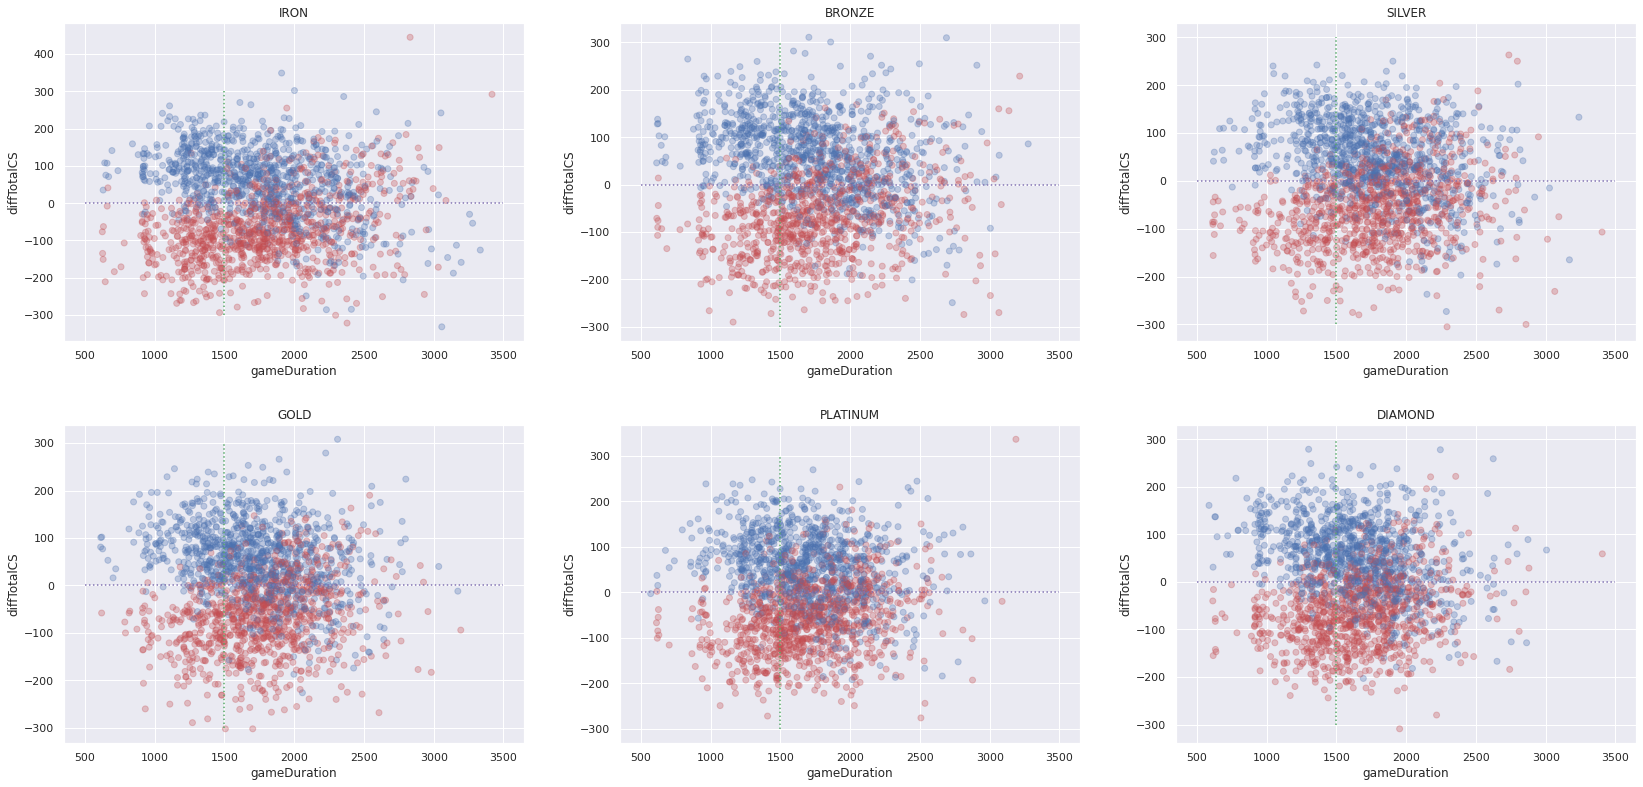

In [30]:
"""
COULD POSSIBLY DO SOME ANALYSIS BASED ON RANK, maybe dont have to though.
maybe thinking a hypothesis test (anova?), but idk what the dependent variable would be.
"""

def sort_ranks(rank):
  tier = rank[0]
  return TIERS.index(tier)
# plot by rank
# print(sorted(list(normalized_df.groupby("gameTier")), key=sort_ranks))

# grid of plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))
fig.tight_layout(pad=5.0)

i = 0
for name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):
  # cs and time
  """group.plot.scatter(x='gameDuration',
                        y='diffTotalCS',
                        c=group.teamWin.map({1: "b", 0: "r"}),
                        alpha=.3,
                        figsize=(8,5),
                        title=name)"""
      
  curr_plot = axs[i // 3, i % 3]
  curr_plot.scatter(x='gameDuration',
                    y='diffTotalCS',
                    data=group,
                    c=group.teamWin.map({1: "b", 0: "r"}),
                    alpha=.3)
  curr_plot.set_title(name)
  curr_plot.set_xlabel("gameDuration")
  curr_plot.set_ylabel("diffTotalCS")
  curr_plot.plot([500, 3500], [0, 0], color='m', linestyle='dotted', linewidth=1.5, alpha=1)
  curr_plot.plot([1500, 1500], [-300, 300], color='g', linestyle='dotted', linewidth=1.5, alpha=1)
  i += 1

Visually, there is not much of a difference between all of the ranks. How accurate is our logistic classifier when run on all of our ranks separately?

nah. how different is the properness of games depending on rank?
we stop at 2500 because theres not a lot of data after 2500.

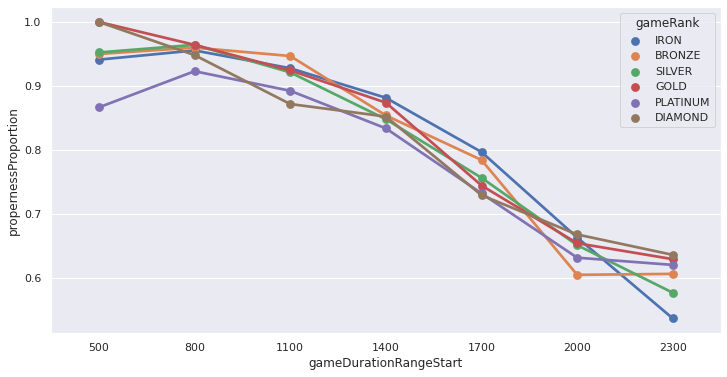

In [35]:
RANGE = 300
properness_proportions_rank_data = {
    "gameDurationRangeStart": [],
    "propernessProportion": [],
    "gameRank": []
}
for name, group in properness_df.groupby("gameRank"):
  for start_time in range(500, 2500, RANGE):
    end_time = start_time + (RANGE - 1)
    time_range = group[group["gameDuration"].between(start_time, end_time, inclusive="both")]

    properness_proportions_rank_data["gameDurationRangeStart"].append(start_time)
    properness_proportions_rank_data["propernessProportion"].append(
        np.nan if len(time_range) == 0 else len(time_range[time_range["properness"]]) / len(time_range)
      )
    properness_proportions_rank_data["gameRank"].append(name)
properness_proportions_rank_df = pd.DataFrame.from_dict(properness_proportions_rank_data)
sns.pointplot(data=properness_proportions_rank_df, x="gameDurationRangeStart", y="propernessProportion", hue="gameRank")
#plt.plot([1500, 1500], [.55, 400], color='g', linestyle='dotted', linewidth=1.5, alpha=1)


unfortunately, looks like theres not much of a discernable trend. maybe we can sort of say that platinum and diamond are sort of less proper in the earlier time ranges, while they are more proper in the later time ranges, but its really not that big of a difference.

In [37]:
#  - PROBABLY DELETE
"""
prediction_accuracy_data = {
    "rank": [],
    "gameDuration": [],
    "accuracy": []
}

for name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):

      

  X = group[["gameDuration", "diffTotalCS"]]
  y = group["teamWin"]

  before_1500_secs = group[group["gameDuration"] < 1500]
  before_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]
  before_1500_y = before_1500_secs["teamWin"]
  after_1500_secs = group[group["gameDuration"] > 1500]
  after_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]
  after_1500_y = after_1500_secs["teamWin"]

  prediction_accuracy_data["rank"].append(name)
  prediction_accuracy_data["accuracy"].append(logistic_model.score(before_1500_X, before_1500_y))
  prediction_accuracy_data["gameDuration"].append("before_1500")
  prediction_accuracy_data["rank"].append(name)
  prediction_accuracy_data["accuracy"].append(logistic_model.score(after_1500_X, after_1500_y))
  prediction_accuracy_data["gameDuration"].append("after_1500")


prediction_accuracy_df = pd.DataFrame.from_dict(prediction_accuracy_data)

sns.set(rc={'figure.figsize':(12, 6)})
sns.pointplot(data=prediction_accuracy_df, x="rank", y="accuracy", hue="gameDuration")"""

'\nprediction_accuracy_data = {\n    "rank": [],\n    "gameDuration": [],\n    "accuracy": []\n}\n\nfor name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):\n\n      \n\n  X = group[["gameDuration", "diffTotalCS"]]\n  y = group["teamWin"]\n\n  before_1500_secs = group[group["gameDuration"] < 1500]\n  before_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]\n  before_1500_y = before_1500_secs["teamWin"]\n  after_1500_secs = group[group["gameDuration"] > 1500]\n  after_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]\n  after_1500_y = after_1500_secs["teamWin"]\n\n  prediction_accuracy_data["rank"].append(name)\n  prediction_accuracy_data["accuracy"].append(logistic_model.score(before_1500_X, before_1500_y))\n  prediction_accuracy_data["gameDuration"].append("before_1500")\n  prediction_accuracy_data["rank"].append(name)\n  prediction_accuracy_data["accuracy"].append(logistic_model.score(after_1500_X, after_1500_y))\n  prediction_accuracy_data[

let's also see whether or not the confidence of the classifier (i.e., how close games usually are to being even in CS) changes between ranks.

In [39]:
"""
prediction_confidence_data = {
    "rank": [],
    "gameDuration": [],
    "confidence": []
}

for name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):

  
  X = group[["gameDuration", "diffTotalCS"]]
  y = group["teamWin"]

  before_1500_secs = group[group["gameDuration"] < 1500]
  before_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]
  after_1500_secs = group[group["gameDuration"] > 1500]
  after_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]

  # we want the distance of the probability from .5: thats the confidence it has
  # towards a certain rank.

  before_1500_probs = list(map(lambda blue_red_prob: abs(.5 - blue_red_prob[0]), logistic_model.predict_proba(before_1500_X)))
  after_1500_probs = list(map(lambda blue_red_prob: abs(.5 - blue_red_prob[0]), logistic_model.predict_proba(after_1500_X)))

  prediction_confidence_data["rank"].append(name)
  prediction_confidence_data["confidence"].append(statistics.mean(before_1500_probs))
  prediction_confidence_data["gameDuration"].append("before_1500")
  prediction_confidence_data["rank"].append(name)
  prediction_confidence_data["confidence"].append(statistics.mean(after_1500_probs))
  prediction_confidence_data["gameDuration"].append("after_1500")


prediction_confidence_df = pd.DataFrame.from_dict(prediction_confidence_data)

sns.set(rc={'figure.figsize':(12, 6)})
sns.pointplot(data=prediction_confidence_df, x="rank", y="confidence", hue="gameDuration")
"""

'\nprediction_confidence_data = {\n    "rank": [],\n    "gameDuration": [],\n    "confidence": []\n}\n\nfor name, group in sorted(list(blue_side_df.groupby("gameRank")), key=sort_ranks):\n\n  \n  X = group[["gameDuration", "diffTotalCS"]]\n  y = group["teamWin"]\n\n  before_1500_secs = group[group["gameDuration"] < 1500]\n  before_1500_X = before_1500_secs[["gameDuration", "diffTotalCS"]]\n  after_1500_secs = group[group["gameDuration"] > 1500]\n  after_1500_X = after_1500_secs[["gameDuration", "diffTotalCS"]]\n\n  # we want the distance of the probability from .5: thats the confidence it has\n  # towards a certain rank.\n\n  before_1500_probs = list(map(lambda blue_red_prob: abs(.5 - blue_red_prob[0]), logistic_model.predict_proba(before_1500_X)))\n  after_1500_probs = list(map(lambda blue_red_prob: abs(.5 - blue_red_prob[0]), logistic_model.predict_proba(after_1500_X)))\n\n  prediction_confidence_data["rank"].append(name)\n  prediction_confidence_data["confidence"].append(statistics.

as we would expect, the confidence of the classifier (scaled to 50%), and thus the predictability of how a game will end, is lower when a game lasts for more than 1500 seconds. interestingly, the confidence for games regardless of duration goes down from iron, bronze and silver, and then remains fairly stable.

thus, we can venture to say that games in the lower ranks are more predictable than games in higher ranks when just looking at CS, which goes against our intuition that lower ranked games are more of a shitfest.

## Tying it Together

TODO bruh

In [42]:
""" TODO
X = blue_side_df[["", ""]] #TODO
Y = blue_side_df["teamWin"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)


# Decision tree classifier
dt = DecisionTreeClassifier()
scores = cross_val_score(dt, X_train, y_train, cv=10)
dt.fit(X_train, y_train)
"""

' TODO\nX = blue_side_df[["", ""]] #TODO\nY = blue_side_df["teamWin"]\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)\n\n\n# Decision tree classifier\ndt = DecisionTreeClassifier()\nscores = cross_val_score(dt, X_train, y_train, cv=10)\ndt.fit(X_train, y_train)\n'

# Conclusion

TODO write stuff

## Further Exploration

TODO write stuff. League of Legends is an incredibly complex game. There are many more factors that we did not take into account that can have an impact on a game's outcome.


We only analyzed team performance, so an analysis on an individual's performance can be interesting to see.
talk about roles 


professional games can also be interesting to see. It is a fact that certain champions are more desirable in professional games, but simutaneously have a very low winrate in regular SOLO/DUO queue games. 